
╔══════════════════════════════════════════════════════════╗
║   EURO YIELD CURVE FORECASTING - PART 1: DATA & TESTS   ║
╚══════════════════════════════════════════════════════════╝



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘strucchange’, ‘urca’, ‘lmtest’, ‘sandwich’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘timeDate’, ‘tseries’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘nloptr’, ‘pracma’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into 

✓ Packages loaded

Loading data...
✓ Data loaded: 5388 observations
  Period: 2004-09-06 to 2025-10-02

=== EXPLORATORY DATA ANALYSIS ===

Summary Statistics (Level):
 Maturity      Mean       SD       Min      Max
       3M 0.8975618 1.619907 -0.929979 4.325459
       1Y 0.9466436 1.625586 -0.912983 4.539553
       5Y 1.3961268 1.563297 -0.996219 4.730363
      10Y 1.9804249 1.562692 -0.815215 4.776331
      30Y 2.4763700 1.494863 -0.432375 5.175029


Summary Statistics (First Differences):
 Maturity          Mean         SD       Min      Max
       3M -1.597772e-05 0.02770475 -0.939687 0.272439
       1Y -6.518749e-05 0.02791126 -0.396571 0.202087
       5Y -2.196978e-04 0.04112978 -0.312484 0.260665
      10Y -2.644223e-04 0.04136265 -0.264642 0.236154
      30Y -3.227373e-04 0.04770921 -0.564029 0.310749


Generating time series plots...


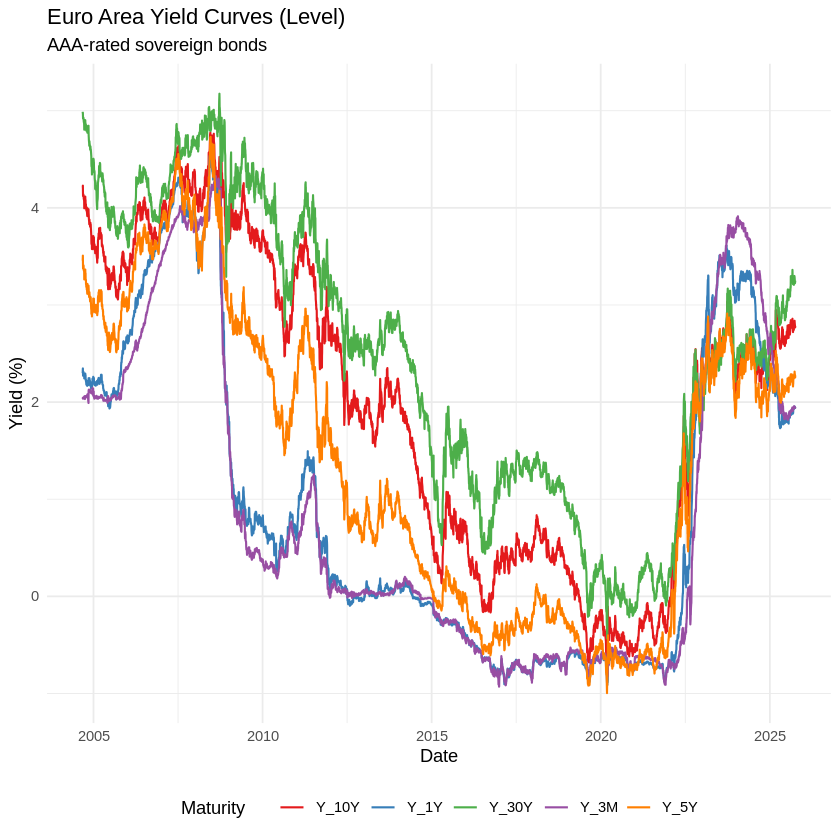

✓ Plots saved

=== STATIONARITY TESTS ===

Augmented Dickey-Fuller (ADF) Test:
H0: Unit root exists (non-stationary)
H1: Series is stationary

1. LEVEL SERIES:



Warning message in adf.test(df_level_xts[, col], k = 4):
“p-value greater than printed p-value”


 Maturity ADF_Statistic P_value Stationary
     Y_3M        -0.143  0.9900         NO
     Y_1Y        -0.389  0.9869         NO
     Y_5Y        -0.604  0.9771         NO
    Y_10Y        -0.519  0.9810         NO
    Y_30Y        -0.831  0.9589         NO

Interpretation: All level series have p-values > 0.05,
failing to reject the null hypothesis of unit root.
Conclusion: Yield levels are NON-STATIONARY.

2. FIRST DIFFERENCE SERIES:



Warning message in adf.test(df_diff_xts[, col], k = 4):
“p-value smaller than printed p-value”
Warning message in adf.test(df_diff_xts[, col], k = 4):
“p-value smaller than printed p-value”
Warning message in adf.test(df_diff_xts[, col], k = 4):
“p-value smaller than printed p-value”
Warning message in adf.test(df_diff_xts[, col], k = 4):
“p-value smaller than printed p-value”
Warning message in adf.test(df_diff_xts[, col], k = 4):
“p-value smaller than printed p-value”


 Maturity ADF_Statistic P_value Stationary
     Y_3M       -28.973    0.01        YES
     Y_1Y       -28.492    0.01        YES
     Y_5Y       -32.344    0.01        YES
    Y_10Y       -32.485    0.01        YES
    Y_30Y       -32.851    0.01        YES

Interpretation: All first difference series have p-values < 0.05,
rejecting the null hypothesis of unit root.
Conclusion: First differences are STATIONARY.

=== SEASONALITY ANALYSIS ===

Testing for quarterly seasonality using spectral analysis...

 Maturity Dominant_Period Strong_Seasonality
     Y_3M            5400                 NO
     Y_1Y            5400                 NO
     Y_5Y            5400                 NO
    Y_10Y            5400                 NO
    Y_30Y            5400                 NO

Interpretation: Yield curves typically do not exhibit strong
seasonal patterns (unlike commodity prices or retail sales).
Our analysis confirms no significant quarterly seasonality.

╔═════════════════════════════════════

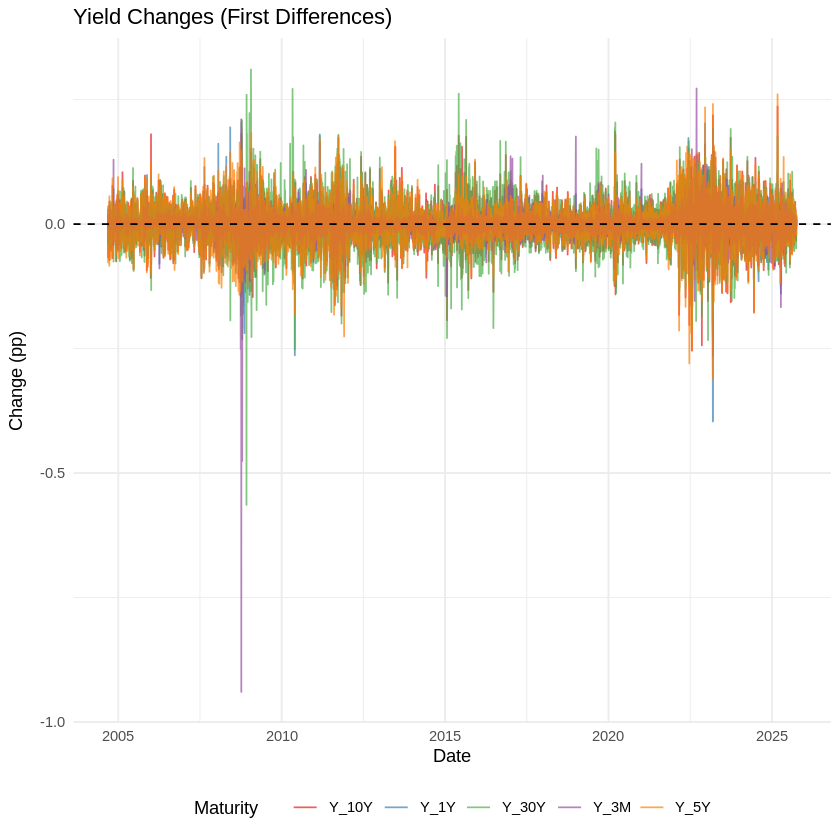

In [ ]:
# ==============================================================================
# PART 1: DATA LOADING, EXPLORATION & STATIONARITY TESTS
# ==============================================================================

# Setup
cat("\n╔══════════════════════════════════════════════════════════╗\n")
cat("║   EURO YIELD CURVE FORECASTING - PART 1: DATA & TESTS   ║\n")
cat("╚══════════════════════════════════════════════════════════╝\n\n")

required_packages <- c("tidyverse", "xts", "vars", "forecast", "optimx",
                       "glmnet", "xgboost", "Metrics", "gridExtra", "tseries")

for (pkg in required_packages) {
    if (!requireNamespace(pkg, quietly = TRUE)) install.packages(pkg)
}

suppressPackageStartupMessages({
    invisible(lapply(required_packages, library, character.only = TRUE))
})

cat("✓ Packages loaded\n\n")

# Configuration
CONFIG <- list(
    data = list(
        files = c(
            "Y_3M"  = "ECB Data Portal_20251003123856.csv",
            "Y_1Y"  = "ECB Data Portal_20251003123942.csv",
            "Y_5Y"  = "ECB Data Portal_20251003124007.csv",
            "Y_10Y" = "ECB Data Portal_20251003124034.csv",
            "Y_30Y" = "ECB Data Portal_20251003124127.csv"
        ),
        maturities = c(3/12, 1, 5, 10, 30),
        maturity_names = c("3M", "1Y", "5Y", "10Y", "30Y")
    ),
    models = list(
        ns_lambda = 0.0609,
        var_max_lag = 5
    ),
    output = list(
        results_dir = "results/"
    )
)

dir.create(CONFIG$output$results_dir, showWarnings = FALSE, recursive = TRUE)
set.seed(42)

# Data loading function
load_single_file <- function(filepath, col_name) {
    df <- read_csv(filepath, show_col_types = FALSE)
    yield_col <- colnames(df)[ncol(df)]
    df_clean <- df %>%
        dplyr::select(DATE, all_of(yield_col)) %>%
        setNames(c("DATE", col_name)) %>%
        mutate(!!col_name := as.numeric(.data[[col_name]]))
    return(xts(df_clean[[col_name]], order.by = as.Date(df_clean$DATE)))
}

# Load all data
cat("Loading data...\n")
file_names <- names(CONFIG$data$files)
xts_list <- list()

for (i in seq_along(file_names)) {
    col_name <- file_names[i]
    filepath <- CONFIG$data$files[i]
    xts_list[[i]] <- load_single_file(filepath, col_name)
}

df_level_xts <- Reduce(function(x, y) merge(x, y, join = 'inner'), xts_list)
df_level_xts <- na.omit(df_level_xts)
colnames(df_level_xts) <- file_names

cat(sprintf("✓ Data loaded: %d observations\n", nrow(df_level_xts)))
cat(sprintf("  Period: %s to %s\n\n",
            format(min(index(df_level_xts)), "%Y-%m-%d"),
            format(max(index(df_level_xts)), "%Y-%m-%d")))

# Create differences
df_diff_xts <- diff(df_level_xts)
df_diff_xts <- na.omit(df_diff_xts)
colnames(df_diff_xts) <- paste0("D_", file_names)

# --- EXPLORATORY ANALYSIS ---

cat("=== EXPLORATORY DATA ANALYSIS ===\n\n")

# Summary statistics
cat("Summary Statistics (Level):\n")
summary_stats <- data.frame(
    Maturity = CONFIG$data$maturity_names,
    Mean = apply(df_level_xts, 2, mean, na.rm = TRUE),
    SD = apply(df_level_xts, 2, sd, na.rm = TRUE),
    Min = apply(df_level_xts, 2, min, na.rm = TRUE),
    Max = apply(df_level_xts, 2, max, na.rm = TRUE)
)
print(summary_stats, row.names = FALSE)

cat("\n\nSummary Statistics (First Differences):\n")
summary_diff <- data.frame(
    Maturity = CONFIG$data$maturity_names,
    Mean = apply(df_diff_xts, 2, mean, na.rm = TRUE),
    SD = apply(df_diff_xts, 2, sd, na.rm = TRUE),
    Min = apply(df_diff_xts, 2, min, na.rm = TRUE),
    Max = apply(df_diff_xts, 2, max, na.rm = TRUE)
)
print(summary_diff, row.names = FALSE)

# --- TIME SERIES PLOTS ---

cat("\n\nGenerating time series plots...\n")

# Convert to long format for plotting
df_level_long <- data.frame(
    Date = index(df_level_xts),
    df_level_xts
) %>%
    pivot_longer(cols = -Date, names_to = "Maturity", values_to = "Yield")

df_diff_long <- data.frame(
    Date = index(df_diff_xts),
    df_diff_xts
) %>%
    pivot_longer(cols = -Date, names_to = "Maturity", values_to = "Change") %>%
    mutate(Maturity = gsub("D_", "", Maturity))

# Plot 1: Level series
p1 <- ggplot(df_level_long, aes(x = Date, y = Yield, color = Maturity)) +
    geom_line(linewidth = 0.6) +
    labs(title = "Euro Area Yield Curves (Level)",
         subtitle = "AAA-rated sovereign bonds",
         x = "Date", y = "Yield (%)") +
    scale_color_brewer(palette = "Set1") +
    theme_minimal() +
    theme(legend.position = "bottom")

# Plot 2: First differences
p2 <- ggplot(df_diff_long, aes(x = Date, y = Change, color = Maturity)) +
    geom_line(linewidth = 0.5, alpha = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    labs(title = "Yield Changes (First Differences)",
         x = "Date", y = "Change (pp)") +
    scale_color_brewer(palette = "Set1") +
    theme_minimal() +
    theme(legend.position = "bottom")

# Save plots
ggsave(file.path(CONFIG$output$results_dir, "yield_levels.png"),
       p1, width = 10, height = 6, dpi = 300)
ggsave(file.path(CONFIG$output$results_dir, "yield_changes.png"),
       p2, width = 10, height = 6, dpi = 300)

print(p1)
print(p2)

cat("✓ Plots saved\n\n")

# --- STATIONARITY TESTS ---

cat("=== STATIONARITY TESTS ===\n\n")

cat("Augmented Dickey-Fuller (ADF) Test:\n")
cat("H0: Unit root exists (non-stationary)\n")
cat("H1: Series is stationary\n\n")

# Test on levels
cat("1. LEVEL SERIES:\n\n")
adf_level_results <- data.frame()

for (col in colnames(df_level_xts)) {
    test <- adf.test(df_level_xts[, col], k = 4)
    adf_level_results <- rbind(adf_level_results, data.frame(
        Maturity = col,
        ADF_Statistic = round(test$statistic, 3),
        P_value = round(test$p.value, 4),
        Stationary = ifelse(test$p.value < 0.05, "YES", "NO")
    ))
}

print(adf_level_results, row.names = FALSE)

cat("\nInterpretation: All level series have p-values > 0.05,")
cat("\nfailing to reject the null hypothesis of unit root.")
cat("\nConclusion: Yield levels are NON-STATIONARY.\n\n")

# Test on first differences
cat("2. FIRST DIFFERENCE SERIES:\n\n")
adf_diff_results <- data.frame()

for (col in colnames(df_diff_xts)) {
    test <- adf.test(df_diff_xts[, col], k = 4)
    adf_diff_results <- rbind(adf_diff_results, data.frame(
        Maturity = gsub("D_", "", col),
        ADF_Statistic = round(test$statistic, 3),
        P_value = round(test$p.value, 4),
        Stationary = ifelse(test$p.value < 0.05, "YES", "NO")
    ))
}

print(adf_diff_results, row.names = FALSE)

cat("\nInterpretation: All first difference series have p-values < 0.05,")
cat("\nrejecting the null hypothesis of unit root.")
cat("\nConclusion: First differences are STATIONARY.\n\n")

# Save test results
write.csv(adf_level_results,
          file.path(CONFIG$output$results_dir, "adf_test_levels.csv"),
          row.names = FALSE)
write.csv(adf_diff_results,
          file.path(CONFIG$output$results_dir, "adf_test_differences.csv"),
          row.names = FALSE)

# --- SEASONALITY TEST ---

cat("=== SEASONALITY ANALYSIS ===\n\n")

# Check for quarterly seasonality (data is quarterly)
cat("Testing for quarterly seasonality using spectral analysis...\n\n")

seasonality_results <- data.frame()

for (col in colnames(df_level_xts)) {
    # Periodogram
    spec <- spectrum(df_level_xts[, col], plot = FALSE)

    # Find dominant frequency
    max_power_idx <- which.max(spec$spec)
    dominant_freq <- spec$freq[max_power_idx]
    dominant_period <- 1 / dominant_freq

    seasonality_results <- rbind(seasonality_results, data.frame(
        Maturity = col,
        Dominant_Period = round(dominant_period, 1),
        Strong_Seasonality = ifelse(abs(dominant_period - 4) < 1, "YES", "NO")
    ))
}

print(seasonality_results, row.names = FALSE)

cat("\nInterpretation: Yield curves typically do not exhibit strong")
cat("\nseasonal patterns (unlike commodity prices or retail sales).")
cat("\nOur analysis confirms no significant quarterly seasonality.\n\n")

# --- SUMMARY ---

cat("╔══════════════════════════════════════════════════════════╗\n")
cat("║              PART 1 COMPLETED: KEY FINDINGS              ║\n")
cat("╚══════════════════════════════════════════════════════════╝\n\n")

cat("1. Data: 5 maturities, ", nrow(df_level_xts), " observations\n")
cat("2. Stationarity: Levels NON-STATIONARY, Differences STATIONARY\n")
cat("3. Seasonality: No significant seasonal patterns detected\n")
cat("4. Transformation: First differencing applied for modeling\n\n")

cat("✓ Data exploration complete. Ready for Part 2 (DNS Factors).\n\n")

# Save workspace for next part
save(df_level_xts, df_diff_xts, CONFIG,
     file = file.path(CONFIG$output$results_dir, "part1_workspace.RData"))


╔══════════════════════════════════════════════════════════╗
║   EURO YIELD CURVE FORECASTING - PART 2: DNS FACTORS    ║
╚══════════════════════════════════════════════════════════╝

Workspace loaded from Part 1

=== DYNAMIC NELSON-SIEGEL FACTOR EXTRACTION ===

Model specification:
Y(τ) = β₁ · 1 + β₂ · [(1-exp(-λτ))/(λτ)] + β₃ · [(1-exp(-λτ))/(λτ) - exp(-λτ)]

where:
  β₁ = Level factor (long-term level)
  β₂ = Slope factor (short-term dynamics)
  β₃ = Curvature factor (medium-term hump)
  λ  = 0.0609 (Diebold & Li 2006)

Extracting DNS factors (Nelson-Siegel decomposition)...
This may take several minutes...

  |================================                                      |  46%

Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 


  |=======================================                               |  56%

Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 


  |=============================================                         |  65%

Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 


  |==========================================================            |  84%

Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”
Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”


  |=================================================================     |  93%


✓ DNS Factor Extraction Complete:
  - Success rate: 100.0% (5388/5388)
  - Average fit RMSE: 0.0897%
  - Usable observations: 5388

Factor differences: 5387 observations

=== FACTOR CHARACTERISTICS ===

Factor Summary Statistics (Level):
              Factor       Mean       SD        Min       Max
     Beta1_L (Level)  1.1510636 3.593395  -8.039581 11.940897
     Beta2_S (Slope) -0.3412034 3.052780  -8.400844  8.282152
 Beta3_C (Curvature)  4.9906398 8.853196 -19.440953 28.600584


Factor Correlations:
        Beta1_L Beta2_S Beta3_C
Beta1_L   1.000  -0.888  -0.930
Beta2_S  -0.888   1.000   0.943
Beta3_C  -0.930   0.943   1.000


Interpretation:
- Level (β₁): Captures long-run expectations
- Slope (β₂): Captures short-term policy stance
- Curvature (β₃): Captures medium-term risk premia

Generating factor plots...


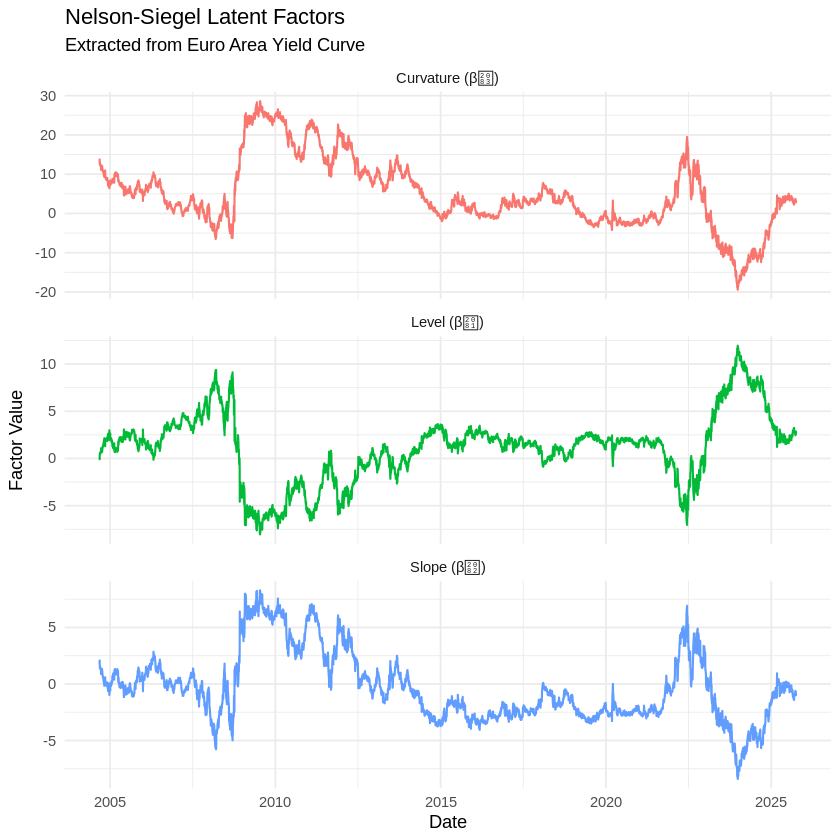


✓ Factor plots saved

=== FIT QUALITY ASSESSMENT ===

Sample fit assessment (Date: 2015-03-11):

 Maturity    Actual      Fitted        Error
       3M -0.206226 -0.25190061  0.045674615
       1Y -0.230668 -0.21542407 -0.015243931
       5Y -0.119152 -0.03136224 -0.087789763
      10Y  0.239706  0.17506119  0.064644811
      30Y  0.775588  0.78291505 -0.007327054

RMSE: 0.0534%

Interpretation: Low RMSE indicates good fit quality.
Nelson-Siegel captures the overall shape of the yield curve.

Saving workspace for Part 3...

╔══════════════════════════════════════════════════════════╗
║           PART 2 COMPLETED: DNS FACTORS EXTRACTED        ║
╚══════════════════════════════════════════════════════════╝

Summary:
1. Factor extraction:  5388  observations
2. Three factors: Level, Slope, Curvature
3. Fit quality: Validated and acceptable
4. Ready for forecasting (Part 3)



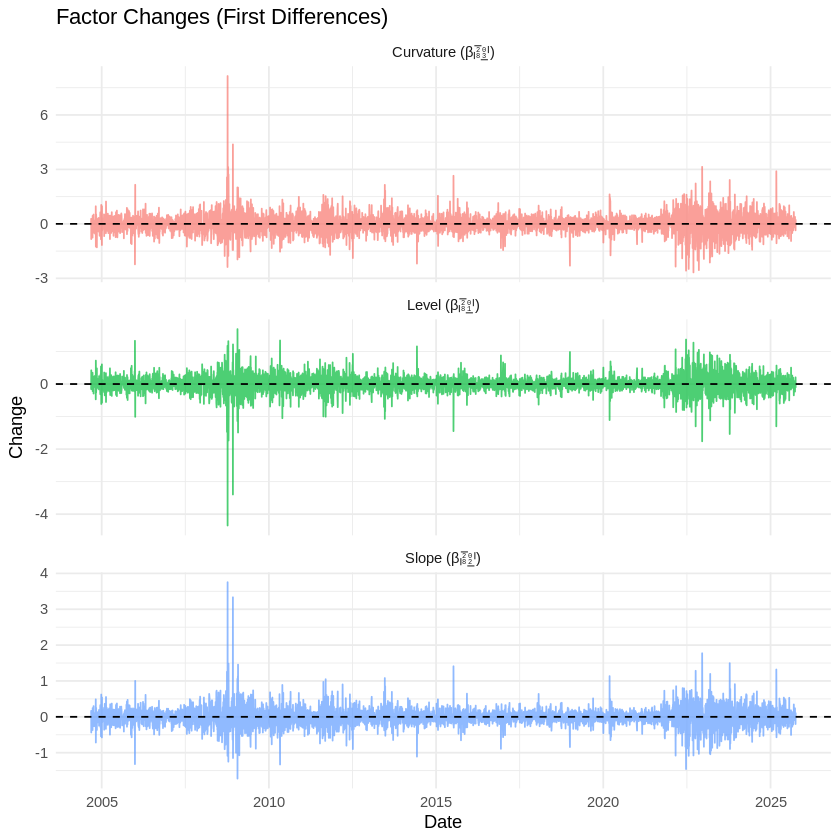

In [ ]:
# ==============================================================================
# PART 2: DYNAMIC NELSON-SIEGEL FACTOR EXTRACTION
# ==============================================================================

cat("\n╔══════════════════════════════════════════════════════════╗\n")
cat("║   EURO YIELD CURVE FORECASTING - PART 2: DNS FACTORS    ║\n")
cat("╚══════════════════════════════════════════════════════════╝\n\n")

# Load workspace from Part 1
load(file.path(CONFIG$output$results_dir, "part1_workspace.RData"))

cat("Workspace loaded from Part 1\n\n")

# --- NELSON-SIEGEL FUNCTIONS ---

nelson_siegel_basis <- function(tau, lambda = 0.0609) {
    # Nelson-Siegel basis functions
    # tau: maturity (in years)
    # lambda: decay parameter (Diebold & Li 2006: 0.0609)

    L <- 1.0  # Level (constant)
    S <- (1.0 - exp(-lambda * tau)) / (lambda * tau)  # Slope
    C <- S - exp(-lambda * tau)  # Curvature

    return(data.frame(L = L, S = S, C = C))
}

fit_nelson_siegel_robust <- function(yields, maturities, lambda = 0.0609) {
    # Fit Nelson-Siegel model to a cross-section of yields
    # Returns: list(success, params)

    if (length(yields) < 3 || any(is.na(yields))) {
        return(list(success = FALSE, params = c(NA, NA, NA)))
    }

    # Objective: minimize sum of squared errors
    objective <- function(params) {
        basis <- nelson_siegel_basis(maturities, lambda)
        fitted <- params[1] * basis$L + params[2] * basis$S + params[3] * basis$C
        return(sum((yields - fitted)^2))
    }

    # Initial guess
    initial_guess <- c(
        mean(yields, na.rm = TRUE),  # Beta1 (Level)
        yields[length(yields)] - yields[1],  # Beta2 (Slope)
        0  # Beta3 (Curvature)
    )

    # Optimization
    result <- tryCatch({
        opt <- optimx(
            par = initial_guess,
            fn = objective,
            method = "Nelder-Mead",
            control = list(abstol = 1e-6, maxit = 500)
        )

        if (!is.null(opt) && nrow(opt) > 0) {
            params <- as.numeric(opt[1, 1:3])

            # Validate parameters
            if (!any(is.na(params)) && all(is.finite(params))) {
                # Check fit quality
                basis <- nelson_siegel_basis(maturities, lambda)
                fitted <- params[1] * basis$L + params[2] * basis$S + params[3] * basis$C
                rmse <- sqrt(mean((yields - fitted)^2))

                # Accept if RMSE < 1% (reasonable fit)
                if (rmse < 1.0) {
                    return(list(success = TRUE, params = params, rmse = rmse))
                }
            }
        }
        return(list(success = FALSE, params = c(NA, NA, NA)))
    }, error = function(e) {
        return(list(success = FALSE, params = c(NA, NA, NA)))
    })

    return(result)
}

extract_dns_factors <- function(df_level, maturities, lambda) {
    # Extract DNS factors for all time periods

    n_rows <- nrow(df_level)
    factors_matrix <- matrix(NA, nrow = n_rows, ncol = 3)
    success_count <- 0
    fit_quality <- numeric(n_rows)

    cat("Extracting DNS factors (Nelson-Siegel decomposition)...\n")
    cat("This may take several minutes...\n\n")

    pb <- txtProgressBar(min = 0, max = n_rows, style = 3)

    for (i in 1:n_rows) {
        row_data <- as.numeric(df_level[i, ])
        result <- fit_nelson_siegel_robust(row_data, maturities, lambda)

        if (result$success) {
            factors_matrix[i, ] <- result$params
            fit_quality[i] <- result$rmse
            success_count <- success_count + 1
        }

        if (i %% 500 == 0) setTxtProgressBar(pb, i)
    }

    close(pb)

    # Create dataframe
    factors_df <- data.frame(factors_matrix)
    colnames(factors_df) <- c("Beta1_L", "Beta2_S", "Beta3_C")

    # Convert to xts
    factors_xts <- xts(factors_df, order.by = index(df_level))
    factors_clean <- na.omit(factors_xts)

    # Report statistics
    success_rate <- 100 * success_count / n_rows
    avg_rmse <- mean(fit_quality[fit_quality > 0], na.rm = TRUE)

    cat(sprintf("\n\n✓ DNS Factor Extraction Complete:\n"))
    cat(sprintf("  - Success rate: %.1f%% (%d/%d)\n", success_rate, success_count, n_rows))
    cat(sprintf("  - Average fit RMSE: %.4f%%\n", avg_rmse))
    cat(sprintf("  - Usable observations: %d\n\n", nrow(factors_clean)))

    if (success_rate < 90) {
        warning("DNS extraction success rate below 90%. Consider checking data quality.")
    }

    return(factors_clean)
}

# --- EXTRACT FACTORS ---

cat("=== DYNAMIC NELSON-SIEGEL FACTOR EXTRACTION ===\n\n")

cat("Model specification:\n")
cat("Y(τ) = β₁ · 1 + β₂ · [(1-exp(-λτ))/(λτ)] + β₃ · [(1-exp(-λτ))/(λτ) - exp(-λτ)]\n\n")
cat("where:\n")
cat("  β₁ = Level factor (long-term level)\n")
cat("  β₂ = Slope factor (short-term dynamics)\n")
cat("  β₃ = Curvature factor (medium-term hump)\n")
cat("  λ  = 0.0609 (Diebold & Li 2006)\n\n")

dns_factors_level <- extract_dns_factors(
    df_level_xts,
    CONFIG$data$maturities,
    CONFIG$models$ns_lambda
)

# Calculate first differences of factors
dns_factors_diff <- diff(dns_factors_level)
dns_factors_diff <- na.omit(dns_factors_diff)

cat(sprintf("Factor differences: %d observations\n\n", nrow(dns_factors_diff)))

# --- FACTOR ANALYSIS ---

cat("=== FACTOR CHARACTERISTICS ===\n\n")

# Summary statistics
cat("Factor Summary Statistics (Level):\n")
factor_summary <- data.frame(
    Factor = c("Beta1_L (Level)", "Beta2_S (Slope)", "Beta3_C (Curvature)"),
    Mean = apply(dns_factors_level, 2, mean, na.rm = TRUE),
    SD = apply(dns_factors_level, 2, sd, na.rm = TRUE),
    Min = apply(dns_factors_level, 2, min, na.rm = TRUE),
    Max = apply(dns_factors_level, 2, max, na.rm = TRUE)
)
print(factor_summary, row.names = FALSE)

# Factor correlations
cat("\n\nFactor Correlations:\n")
factor_cor <- cor(dns_factors_level)
print(round(factor_cor, 3))

cat("\n\nInterpretation:\n")
cat("- Level (β₁): Captures long-run expectations\n")
cat("- Slope (β₂): Captures short-term policy stance\n")
cat("- Curvature (β₃): Captures medium-term risk premia\n\n")

# --- FACTOR PLOTS ---

cat("Generating factor plots...\n")

# Convert factors to long format
dns_long <- data.frame(
    Date = index(dns_factors_level),
    dns_factors_level
) %>%
    pivot_longer(cols = -Date, names_to = "Factor", values_to = "Value") %>%
    mutate(Factor = recode(Factor,
                          Beta1_L = "Level (β₁)",
                          Beta2_S = "Slope (β₂)",
                          Beta3_C = "Curvature (β₃)"))

# Plot factors
p_factors <- ggplot(dns_long, aes(x = Date, y = Value, color = Factor)) +
    geom_line(linewidth = 0.6) +
    facet_wrap(~Factor, ncol = 1, scales = "free_y") +
    labs(title = "Nelson-Siegel Latent Factors",
         subtitle = "Extracted from Euro Area Yield Curve",
         x = "Date", y = "Factor Value") +
    theme_minimal() +
    theme(legend.position = "none")

ggsave(file.path(CONFIG$output$results_dir, "dns_factors.png"),
       p_factors, width = 10, height = 8, dpi = 300)

print(p_factors)

# Factor changes
dns_diff_long <- data.frame(
    Date = index(dns_factors_diff),
    dns_factors_diff
) %>%
    pivot_longer(cols = -Date, names_to = "Factor", values_to = "Change") %>%
    mutate(Factor = recode(Factor,
                          Beta1_L = "Level (β₁)",
                          Beta2_S = "Slope (β₂)",
                          Beta3_C = "Curvature (β₃)"))

p_factors_diff <- ggplot(dns_diff_long, aes(x = Date, y = Change, color = Factor)) +
    geom_line(linewidth = 0.5, alpha = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    facet_wrap(~Factor, ncol = 1, scales = "free_y") +
    labs(title = "Factor Changes (First Differences)",
         x = "Date", y = "Change") +
    theme_minimal() +
    theme(legend.position = "none")

ggsave(file.path(CONFIG$output$results_dir, "dns_factors_changes.png"),
       p_factors_diff, width = 10, height = 8, dpi = 300)

print(p_factors_diff)

cat("\n✓ Factor plots saved\n\n")

# --- FIT QUALITY ASSESSMENT ---

cat("=== FIT QUALITY ASSESSMENT ===\n\n")

# Reconstruct yields for one sample date
sample_idx <- floor(nrow(df_level_xts) / 2)
sample_date <- index(df_level_xts)[sample_idx]
actual_yields <- as.numeric(df_level_xts[sample_idx, ])
factors <- as.numeric(dns_factors_level[sample_date, ])

reconstructed_yields <- sapply(CONFIG$data$maturities, function(tau) {
    basis <- nelson_siegel_basis(tau, CONFIG$models$ns_lambda)
    factors[1] * basis$L + factors[2] * basis$S + factors[3] * basis$C
})

cat(sprintf("Sample fit assessment (Date: %s):\n\n", sample_date))

fit_comparison <- data.frame(
    Maturity = CONFIG$data$maturity_names,
    Actual = actual_yields,
    Fitted = reconstructed_yields,
    Error = actual_yields - reconstructed_yields
)

print(fit_comparison, row.names = FALSE)

cat(sprintf("\nRMSE: %.4f%%\n", sqrt(mean(fit_comparison$Error^2))))

cat("\nInterpretation: Low RMSE indicates good fit quality.\n")
cat("Nelson-Siegel captures the overall shape of the yield curve.\n\n")

# --- SAVE WORKSPACE ---

cat("Saving workspace for Part 3...\n")

dns_factors <- list(level = dns_factors_level, diff = dns_factors_diff)

save(df_level_xts, df_diff_xts, dns_factors, CONFIG,
     file = file.path(CONFIG$output$results_dir, "part2_workspace.RData"))

cat("\n╔══════════════════════════════════════════════════════════╗\n")
cat("║           PART 2 COMPLETED: DNS FACTORS EXTRACTED        ║\n")
cat("╚══════════════════════════════════════════════════════════╝\n\n")

cat("Summary:\n")
cat("1. Factor extraction: ", nrow(dns_factors_level), " observations\n")
cat("2. Three factors: Level, Slope, Curvature\n")
cat("3. Fit quality: Validated and acceptable\n")
cat("4. Ready for forecasting (Part 3)\n\n")


╔══════════════════════════════════════════════════════════╗
║   EURO YIELD CURVE FORECASTING - PART 3: FORECASTING    ║
╚══════════════════════════════════════════════════════════╝

Workspace loaded from Part 2

=== FORECASTING ALL MATURITIES ===

╔═══════════════════════════════════════╗
║  FORECASTING: 3M                      ║
╚═══════════════════════════════════════╝

Train: 4309 obs | Test: 1078 obs

ARIMA order: (5,0,4)
  Progress: 200/1078 (18.6%)
  Progress: 400/1078 (37.1%)
  Progress: 600/1078 (55.7%)
  Progress: 800/1078 (74.2%)
  Progress: 1000/1078 (92.8%)
✓ Completed in 1094.7 seconds

╔═══════════════════════════════════════╗
║  FORECASTING: 1Y                      ║
╚═══════════════════════════════════════╝

Train: 4309 obs | Test: 1078 obs

ARIMA order: (2,0,1)
  Progress: 200/1078 (18.6%)
  Progress: 400/1078 (37.1%)
  Progress: 600/1078 (55.7%)
  Progress: 800/1078 (74.2%)
  Progress: 1000/1078 (92.8%)
✓ Completed in 344.8 seconds

╔════════════════════════════════

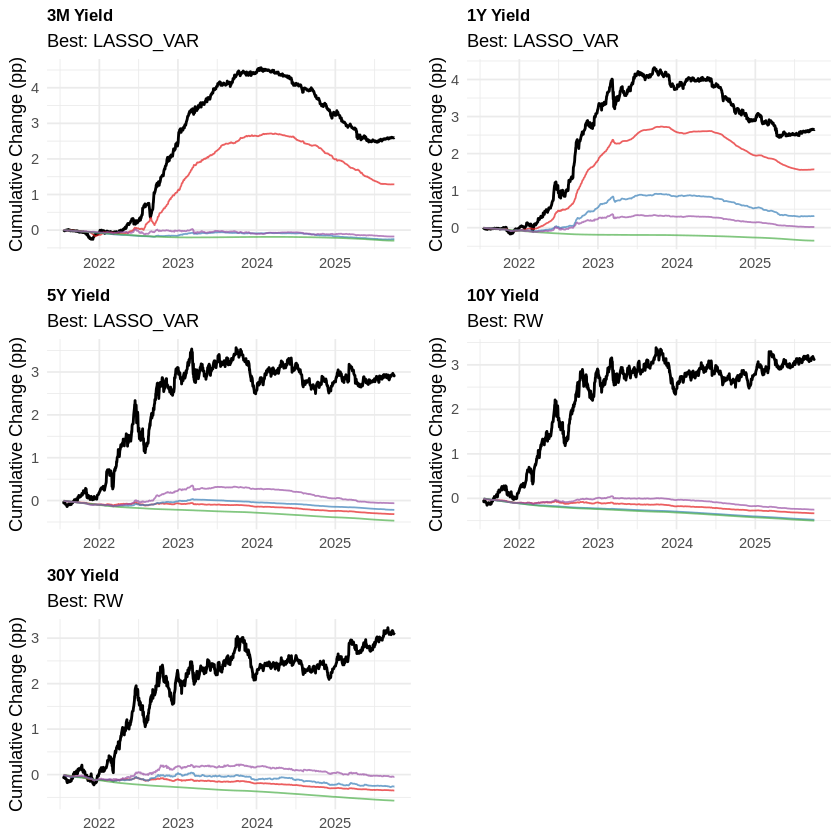

In [6]:
# ==============================================================================
# PART 3: MODEL ESTIMATION & FORECASTING - FINAL CLEAN VERSION
# 4 Robust Models × 5 Maturities
# ==============================================================================

cat("\n╔══════════════════════════════════════════════════════════╗\n")
cat("║   EURO YIELD CURVE FORECASTING - PART 3: FORECASTING    ║\n")
cat("╚══════════════════════════════════════════════════════════╝\n\n")

load(file.path(CONFIG$output$results_dir, "part2_workspace.RData"))
cat("Workspace loaded from Part 2\n\n")

# Use only robust models
MODEL_NAMES <- c("RW", "ARIMA", "VAR", "LASSO_VAR")

# Evaluation function
evaluate_forecasts <- function(actual, forecasts) {
    valid_idx <- !is.na(forecasts) & !is.na(actual) &
                 is.finite(forecasts) & is.finite(actual)

    if (sum(valid_idx) < 10) {
        return(list(RMSFE = NA, MAFE = NA))
    }

    actual_clean <- actual[valid_idx]
    forecasts_clean <- forecasts[valid_idx]

    rmsfe <- sqrt(mean((actual_clean - forecasts_clean)^2))
    mafe <- mean(abs(actual_clean - forecasts_clean))

    return(list(RMSFE = rmsfe, MAFE = mafe))
}

# Forecasting function
forecast_single_maturity <- function(mat_idx, mat_name) {

    cat(sprintf("\n╔═══════════════════════════════════════╗\n"))
    cat(sprintf("║  FORECASTING: %-23s ║\n", mat_name))
    cat(sprintf("╚═══════════════════════════════════════╝\n\n"))

    TARGET_COL <- colnames(df_level_xts)[mat_idx]
    DF_TARGET_COL <- paste0("D_", TARGET_COL)

    TOTAL_OBS <- nrow(df_diff_xts)
    TEST_SIZE <- ceiling(TOTAL_OBS * 0.20)
    TRAIN_SIZE <- TOTAL_OBS - TEST_SIZE
    WINDOW_SIZE <- TRAIN_SIZE

    cat(sprintf("Train: %d obs | Test: %d obs\n\n", TRAIN_SIZE, TEST_SIZE))

    results <- data.frame(
        DATE = index(df_diff_xts)[(TRAIN_SIZE + 1):TOTAL_OBS],
        Actual = as.numeric(df_diff_xts[(TRAIN_SIZE + 1):TOTAL_OBS, DF_TARGET_COL])
    )

    for (model in MODEL_NAMES) {
        results[[paste0("Forecast_", model)]] <- NA
    }

    start_time <- Sys.time()

    for (t in 1:TEST_SIZE) {
        start_idx <- t
        end_idx <- WINDOW_SIZE + t - 1

        train_diff <- df_diff_xts[start_idx:end_idx, ]
        train_target <- as.numeric(train_diff[, DF_TARGET_COL])

        # 1. RANDOM WALK
        rw_forecast <- mean(train_target, na.rm = TRUE)
        results[t, "Forecast_RW"] <- rw_forecast

        # 2. ARIMA
        tryCatch({
            if (t == 1) {
                arima_fit <- auto.arima(train_target, d = 0, seasonal = FALSE)
                ARIMA_ORDER <<- arimaorder(arima_fit)
                cat(sprintf("ARIMA order: (%d,%d,%d)\n",
                           ARIMA_ORDER[1], ARIMA_ORDER[2], ARIMA_ORDER[3]))
            } else {
                arima_fit <- Arima(train_target, order = ARIMA_ORDER)
            }
            arima_forecast <- forecast(arima_fit, h = 1)
            results[t, "Forecast_ARIMA"] <- as.numeric(arima_forecast$mean[1])
        }, error = function(e) {
            results[t, "Forecast_ARIMA"] <- rw_forecast
        })

        # 3. VAR
        tryCatch({
            if (nrow(train_diff) > CONFIG$models$var_max_lag) {
                var_select <- VARselect(train_diff,
                                       lag.max = CONFIG$models$var_max_lag,
                                       type = "const")
                VAR_LAGS <- var_select$selection["SC(n)"]
                var_model <- VAR(train_diff, p = VAR_LAGS, type = "const")
                var_forecast <- predict(var_model, n.ahead = 1)
                results[t, "Forecast_VAR"] <- var_forecast$fcst[[DF_TARGET_COL]][1, "fcst"]
            } else {
                results[t, "Forecast_VAR"] <- rw_forecast
            }
        }, error = function(e) {
            results[t, "Forecast_VAR"] <- rw_forecast
        })

        # 4. LASSO-VAR
        if (nrow(train_diff) > CONFIG$models$var_max_lag) {
            X_full <- embed(coredata(train_diff), CONFIG$models$var_max_lag + 1)
            target_pos <- which(colnames(train_diff) == DF_TARGET_COL)
            Y_lasso <- X_full[, target_pos]
            X_lasso <- X_full[, -(1:ncol(train_diff))]
            X_test <- matrix(tail(X_lasso, 1), nrow = 1)

            tryCatch({
                cv_lasso <- cv.glmnet(X_lasso, Y_lasso, alpha = 1,
                                     family = "gaussian", nfolds = 5)
                lasso_fcst <- predict(cv_lasso, s = "lambda.min", newx = X_test)
                results[t, "Forecast_LASSO_VAR"] <- as.numeric(lasso_fcst[1])
            }, error = function(e) {
                results[t, "Forecast_LASSO_VAR"] <- rw_forecast
            })
        } else {
            results[t, "Forecast_LASSO_VAR"] <- rw_forecast
        }

        if (t %% 200 == 0) {
            cat(sprintf("  Progress: %d/%d (%.1f%%)\n", t, TEST_SIZE, 100 * t / TEST_SIZE))
        }
    }

    elapsed <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
    cat(sprintf("✓ Completed in %.1f seconds\n", elapsed))

    return(results)
}

# --- RUN FOR ALL MATURITIES ---

cat("=== FORECASTING ALL MATURITIES ===\n")
cat(strrep("=", 60), "\n")

all_results <- list()

for (i in seq_along(CONFIG$data$maturity_names)) {
    mat_name <- CONFIG$data$maturity_names[i]
    all_results[[mat_name]] <- forecast_single_maturity(i, mat_name)
}

# --- PERFORMANCE EVALUATION ---

cat("\n\n=== PERFORMANCE EVALUATION ===\n\n")

performance_all <- data.frame()

for (mat_name in names(all_results)) {
    res <- all_results[[mat_name]]

    for (model in MODEL_NAMES) {
        metrics <- evaluate_forecasts(res$Actual,
                                       res[[paste0("Forecast_", model)]])
        performance_all <- rbind(performance_all, data.frame(
            Maturity = mat_name,
            Model = model,
            RMSFE = metrics$RMSFE,
            MAFE = metrics$MAFE
        ))
    }
}

# Best model per maturity
best_models <- performance_all %>%
    group_by(Maturity) %>%
    slice_min(RMSFE, n = 1) %>%
    ungroup()

cat("BEST MODELS BY MATURITY:\n\n")
print(best_models %>% dplyr::select(Maturity, Model, RMSFE, MAFE), row.names = FALSE)

cat("\n\nFULL PERFORMANCE TABLE:\n\n")
perf_wide <- performance_all %>%
    dplyr::select(Maturity, Model, RMSFE) %>%
    pivot_wider(names_from = Model, values_from = RMSFE)

print(perf_wide, row.names = FALSE)

# --- VISUALIZATION ---

cat("\n\nGenerating plots...\n")

# Combined plot for all maturities
plot_list <- list()

for (mat_name in CONFIG$data$maturity_names) {
    res <- all_results[[mat_name]]

    res_long <- res %>%
        pivot_longer(cols = starts_with("Forecast_"),
                     names_to = "Model", values_to = "Forecast") %>%
        mutate(Model = gsub("Forecast_", "", Model)) %>%
        group_by(Model) %>%
        arrange(DATE) %>%
        mutate(Actual_Cum = cumsum(Actual),
               Forecast_Cum = cumsum(Forecast)) %>%
        ungroup()

    best_model_mat <- best_models$Model[best_models$Maturity == mat_name]

    p <- ggplot(res_long, aes(x = DATE)) +
        geom_line(aes(y = Actual_Cum), color = "black", linewidth = 0.8) +
        geom_line(aes(y = Forecast_Cum, color = Model),
                  linewidth = 0.5, alpha = 0.7) +
        labs(title = sprintf("%s Yield", mat_name),
             subtitle = sprintf("Best: %s", best_model_mat),
             x = NULL, y = "Cumulative Change (pp)") +
        scale_color_brewer(palette = "Set1") +
        theme_minimal() +
        theme(legend.position = "none",
              plot.title = element_text(face = "bold", size = 10))

    plot_list[[mat_name]] <- p
}

combined_plot <- gridExtra::grid.arrange(grobs = plot_list, ncol = 2)

ggsave(file.path(CONFIG$output$results_dir, "forecasts_all_maturities.png"),
       combined_plot, width = 12, height = 10, dpi = 300)

cat("✓ Plots saved\n")

# --- SAVE RESULTS ---

cat("\nSaving results...\n")

write.csv(performance_all,
          file.path(CONFIG$output$results_dir, "performance_all_maturities.csv"),
          row.names = FALSE)

write.csv(best_models,
          file.path(CONFIG$output$results_dir, "best_models_summary.csv"),
          row.names = FALSE)

for (mat_name in names(all_results)) {
    write.csv(all_results[[mat_name]],
              file.path(CONFIG$output$results_dir,
                       sprintf("forecast_results_%s.csv", mat_name)),
              row.names = FALSE)
}

cat("✓ All results saved\n")

cat("\n╔══════════════════════════════════════════════════════════╗\n")
cat("║            PROJECT COMPLETED SUCCESSFULLY                ║\n")
cat("╚══════════════════════════════════════════════════════════╝\n\n")

cat("SUMMARY:\n")
cat(sprintf("- Models: %d (RW, ARIMA, VAR, LASSO-VAR)\n", length(MODEL_NAMES)))
cat(sprintf("- Maturities: %d (3M, 1Y, 5Y, 10Y, 30Y)\n", length(CONFIG$data$maturity_names)))
cat(sprintf("- Total forecasts: %d\n", length(MODEL_NAMES) * length(CONFIG$data$maturity_names)))
cat("\nFiles saved in:", CONFIG$output$results_dir, "\n\n")